<a href="https://colab.research.google.com/github/Yisahak/Yisahak/blob/main/LSTM_GRU_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [6]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Actual')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('Mw Network Fault Prediction')
    plt.xlabel('Time')
    plt.ylabel('Fault Prediction')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    mae=mean_absolute_error(test, predicted)
    mse=mean_squared_error(test, predicted)
    r2 =metrics.r2_score(test, predicted)
    print("RMSE is {}.".format(rmse))
    print("MAE is {}.".format(mae))
    print("MSE is {}.".format(mse))
    print("R2 is {}.".format(r2))

In [4]:
# First, we get the data
dataset = pd.read_csv('/content/MW_LOG_111.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Fault_Type,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,year,month,week_day
Date,,,,,,,,,,,
2022-11-10 15:49:00,1,3,146,0,0,1,0,0,2022,11,3
2022-11-10 15:49:00,5,3,640,0,0,1,0,0,2022,11,3
2022-11-10 15:51:00,6,3,1349,0,0,1,0,0,2022,11,3
2022-11-10 15:52:00,2,1,688,1,0,0,0,0,2022,11,3
2022-11-10 15:53:00,1,3,19,0,0,1,0,0,2022,11,3


In [7]:
dataset.shape

(105697, 11)

In [48]:
# Checking for missing values
training_set = dataset[: 84497].iloc[:,1:2].values
test_set = dataset[84497 :].iloc[:,1:2].values

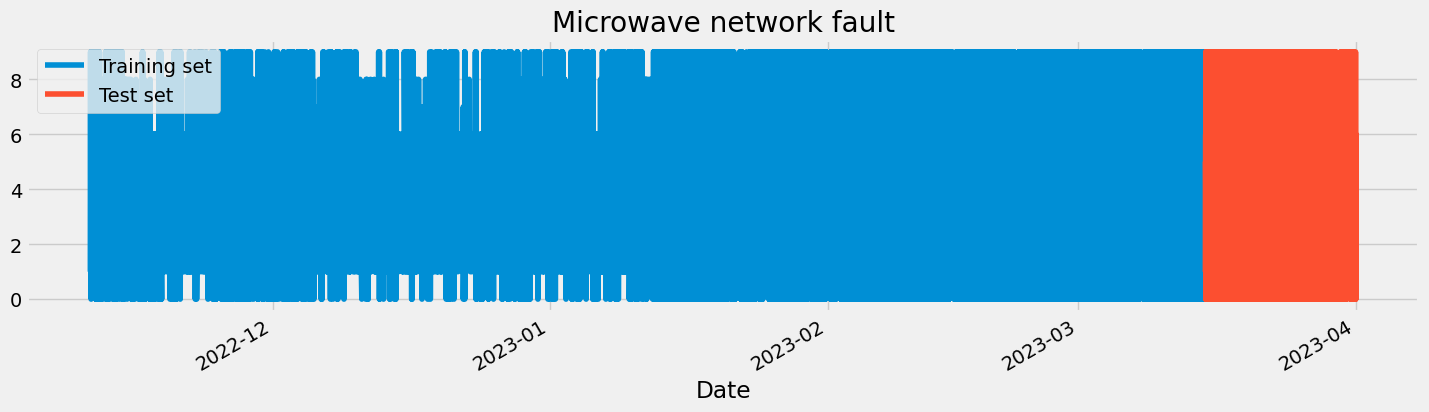

In [41]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["Fault_Type"][: 84497].plot(figsize=(16,4),legend=True)
dataset["Fault_Type"][84497 :].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('Microwave network fault')
plt.show()

In [11]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [42]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,84497):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [14]:
# The LSTM architecture
model_LSTM = Sequential()
# First LSTM layer with Dropout regularisation
model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_LSTM.add(Dropout(0.2))
# Second LSTM layer
model_LSTM.add(LSTM(units=50, return_sequences=True))
model_LSTM.add(Dropout(0.2))
# Third LSTM layer
model_LSTM.add(LSTM(units=50, return_sequences=True))
model_LSTM.add(Dropout(0.2))
# Fourth LSTM layer
model_LSTM.add(LSTM(units=50))
model_LSTM.add(Dropout(0.2))
# The output layer
model_LSTM.add(Dense(units=1))

model_LSTM.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f54108810c0>>

In [15]:
# Compiling the RNN
model_LSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
model_LSTM.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
2641/2641 [==============================] - 339s 125ms/step - loss: 0.1732
Epoch 2/5
2641/2641 [==============================] - 324s 123ms/step - loss: 0.1581
Epoch 3/5
2641/2641 [==============================] - 325s 123ms/step - loss: 0.1564
Epoch 4/5
2641/2641 [==============================] - 323s 122ms/step - loss: 0.1545
Epoch 5/5
2641/2641 [==============================] - 322s 122ms/step - loss: 0.1535


In [16]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["Fault_Type"][: 84557],dataset["Fault_Type"][84557 :]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [44]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,21079):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_Microwave_Fault = model_LSTM.predict(X_test)
predicted_Microwave_Fault = sc.inverse_transform(predicted_Microwave_Fault)

657/657 [==============================] - 22s 34ms/step


In [49]:
test_set.shape

(21200, 1)

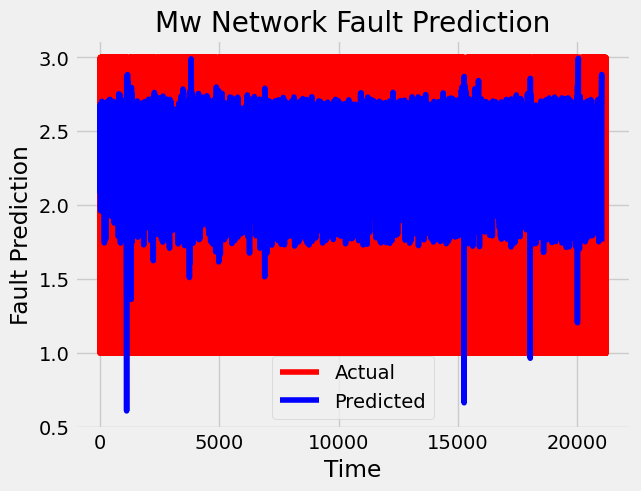

In [45]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_Microwave_Fault)

In [46]:
# Evaluating our model
return_rmse(test_set,predicted_Microwave_Fault)
return_mae=mean_absolute_error(test_set,predicted_Microwave_Fault)
return_mse=mean_squared_error(test_set,predicted_Microwave_Fault)
return_r2 =metrics.r2_score(test_set,predicted_Microwave_Fault)

ValueError: ignored

In [22]:
# The GRU architecture
model_GRU = Sequential()
# First GRU layer with Dropout regularisation
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_GRU.add(Dropout(0.2))
# Second LSTM layer
model_GRU.add(GRU(units=50, return_sequences=True))
model_GRU.add(Dropout(0.2))
# Third LSTM layer
model_GRU.add(GRU(units=50, return_sequences=True))
model_GRU.add(Dropout(0.2))
# Fourth LSTM layer
model_GRU.add(GRU(units=50))
model_GRU.add(Dropout(0.2))
# The output layer
model_GRU.add(Dense(units=1))

model_GRU.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f540ee37a90>>

In [23]:
# Compiling the RNN
model_GRU.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
model_GRU.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
2641/2641 [==============================] - 354s 131ms/step - loss: 0.1641
Epoch 2/5
2641/2641 [==============================] - 341s 129ms/step - loss: 0.1589
Epoch 3/5
2641/2641 [==============================] - 337s 128ms/step - loss: 0.1582
Epoch 4/5
2641/2641 [==============================] - 339s 128ms/step - loss: 0.1575
Epoch 5/5
2641/2641 [==============================] - 339s 128ms/step - loss: 0.1562


In [24]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["Fault_Type"][: 84557],dataset["Fault_Type"][84557 :]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [28]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,21139):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_Microwave_Fault = model_GRU.predict(X_test)
predicted_Microwave_Fault = sc.inverse_transform(predicted_Microwave_Fault)

659/659 [==============================] - 19s 28ms/step


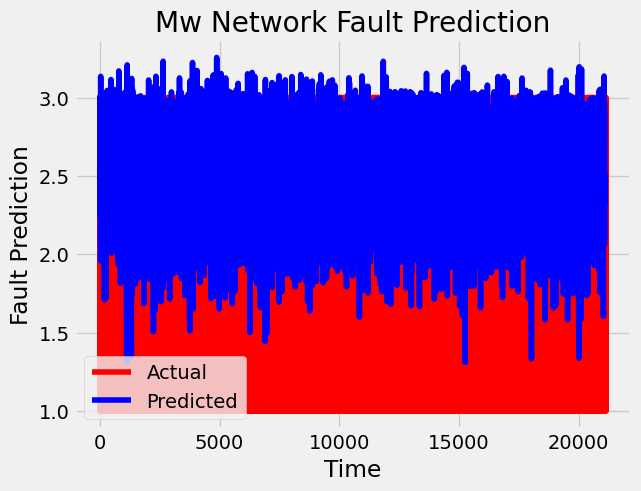

In [29]:
# Visualizing the results for GRU
plot_predictions(test_set,predicted_Microwave_Fault)

In [31]:
# Evaluating our model
return_rmse(test_set,predicted_Microwave_Fault)
return_mae=mean_absolute_error(test_set,predicted_Microwave_Fault)
return_mse=mean_squared_error(test_set,predicted_Microwave_Fault)
return_r2 =metrics.r2_score(test_set,predicted_Microwave_Fault


ValueError: ignored